# Endcrypt your data file and upload to Dropbox (using API)

In [1]:
# Author: Pranab Das (Twitter: @pranab_das)
# Version: 20191024 
# Requirements: Dropbox Python SDK

import dropbox 
from getpass import getpass
from simplecrypt import encrypt, decrypt
import numpy as np

# Open the text file and read as binary 
fid = open('example_spectrum.txt', 'rb')
file_bin_data = fid.read()
fid.close()

# encrypt your data 
encdata = encrypt(getpass("Data encryption password: "), file_bin_data)

# Get your Dropbox Access token and create dropbox object
# Here I've encrypted access token, you can get yours at 
# https://www.dropbox.com/developers/apps/create

# dbx = dropbox.Dropbox('Access token')
dbx = dropbox.Dropbox(decrypt(getpass("Dropbox access token password: "), b'sc\x00\x02\xb6\xd2q\xc2\x7fs\xc3H\x07\x96*\xacS\xb3w$a"\xf7\x0c\x8b\xce\xf6\xcb\x08\xd7\xff\xf4\xc8\'\xaa\xb3Q\xecg\xaf\x04T3\xd9\xe1\xcd\xb1\n\xefN\xedE\xf1\xaf4\x17\xebRE\xf1\xf6\xa9,X=\x88n\x12y\xc86N\xa0\xaf\xbf#\x82\x86\xab\x96\xf9\x86\xbaHc\xef\x8cq?i\x96\xa7@\xf5\x92a\xf0\x91\xbe\x1c\n\x86^\xfe`X\xe4\xa7\x08NN\x08\x9c/\xa4{v\x19n\x1a<\x85@\x9a\x07\x8a\xa4\xc8\x8c\x158\xf3').decode('utf8'))

# Write encrypted data to specific dropbox location (Note the Overwrite mode)
dbx.files_upload(encdata, '/ARPES_Data/data.enc', mode=dropbox.files.WriteMode.overwrite)

Data encryption password: ········
Dropbox access token password: ········


FileMetadata(name='data.enc', id='id:70kh-jgeO_AAAAAAAAAAIg', client_modified=datetime.datetime(2019, 10, 24, 8, 1, 37), server_modified=datetime.datetime(2019, 10, 24, 8, 1, 37), rev='01595a3715d26ec000000016ecd49f0', size=4141739, path_lower='/arpes_data/data.enc', path_display='/ARPES_Data/data.enc', parent_shared_folder_id=None, media_info=None, symlink_info=None, sharing_info=None, is_downloadable=True, export_info=None, property_groups=None, has_explicit_shared_members=None, content_hash='028623fe28625ebb5d47c33f2411834aa08a5787fbcb717a4e8e17e3eac66760')

### Access the data and decrypt

In [2]:
# Read the file from Dropbox
md, read_encdata = dbx.files_download('/ARPES_Data/data.enc')
read_encdata = read_encdata.content

# Decrypt as plaintext
data_plaintext = decrypt(getpass("Decryption password: "), read_encdata).decode('utf8')

Decryption password: ········


### Process the data as you need

In [3]:
contents = data_plaintext.splitlines()
energy_length = contents[7] 
start_string = contents[7].find("=") + 1 
end_string = len(contents[7])
energy_length = int(contents[7][start_string : end_string]) 
print("Size of energy dimension =", energy_length)

angle_length = contents[10] 
start_string = contents[10].find("=") + 1 
end_string = len(contents[10])
angle_length = int(contents[10][start_string : end_string]) 
print("Size of angle dimension =", angle_length)

angle = contents[11] 
start_string = contents[11].find("=") + 1 
end_string = len(contents[11]) 
angle_temp = contents[11][start_string : end_string]

angle = np.linspace(0, 0, angle_length)

start_string = 0 
for ii in range(angle_length):
    end_string = angle_temp.find(" ", start_string)
    angle[ii] = float(angle_temp[start_string : end_string]) 
    start_string = end_string + 1

energy = np.linspace(0, 0, energy_length)

intensity = np.ndarray((energy_length, angle_length)) 

for ii in range(energy_length):
    intensity_temp = contents[57 + ii]
    end_string = len(intensity_temp)
    intensity_temp = intensity_temp[1 : end_string] 

    start_string = 0
    for jj in range(angle_length + 1): 
        end_string = intensity_temp.find("  ", start_string)
        if jj == 0 : 
            energy[ii] = float(intensity_temp[start_string : end_string]) 
            start_string = end_string + 1
        elif jj > 0 :
            intensity[ii][jj - 1] = float(intensity_temp[start_string : \
                     end_string]) 
            start_string = end_string + 1

Size of energy dimension = 301
Size of angle dimension = 571


In [4]:
def my_image_plot(data, axis1, axis2):
    import matplotlib.pyplot as plt 
    from matplotlib.ticker import AutoMinorLocator

    x_start = axis1[0]
    x_end = axis1[len(axis1) - 1] 
    y_start = axis2[0]
    y_end = axis2[len(axis2) - 1]
    
    large = 22; med = 16; #small = 12
    params = {'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'image.origin': 'lower', 
          'xtick.major.size': 8,
          'ytick.major.size': 8, 
          'xtick.major.width': 1.5, 
          'ytick.major.width': 1.5, 
          'xtick.minor.size': 4, 
          'xtick.minor.width': 1, 
          'ytick.minor.size': 4, 
          'ytick.minor.width': 1, 
          'axes.linewidth': 1.5, 
          'font.family': 'Sans'} 
    plt.rcParams.update(params)
    fig = plt.figure(figsize = (8, 6), dpi = 300)
    plt.imshow(data, aspect = 'auto', extent = (x_start, x_end, y_start, \
                                                     y_end))
    plt.xlabel('Angle (deg)') 
    plt.ylabel('E$_{k}$ (eV)') 
#    plt.gca().invert_yaxis()
#    plt.gca().invert_xaxis()
#    plt.locator_params(axis='y', nbins=5)
#    plt.locator_params(axis='x', nbins=5)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.4))
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
#    plt.clim(0, 4000) # Find data.min() and data.max()
    plt.set_cmap('magma_r') 
#    fig.savefig("fig.pdf")  

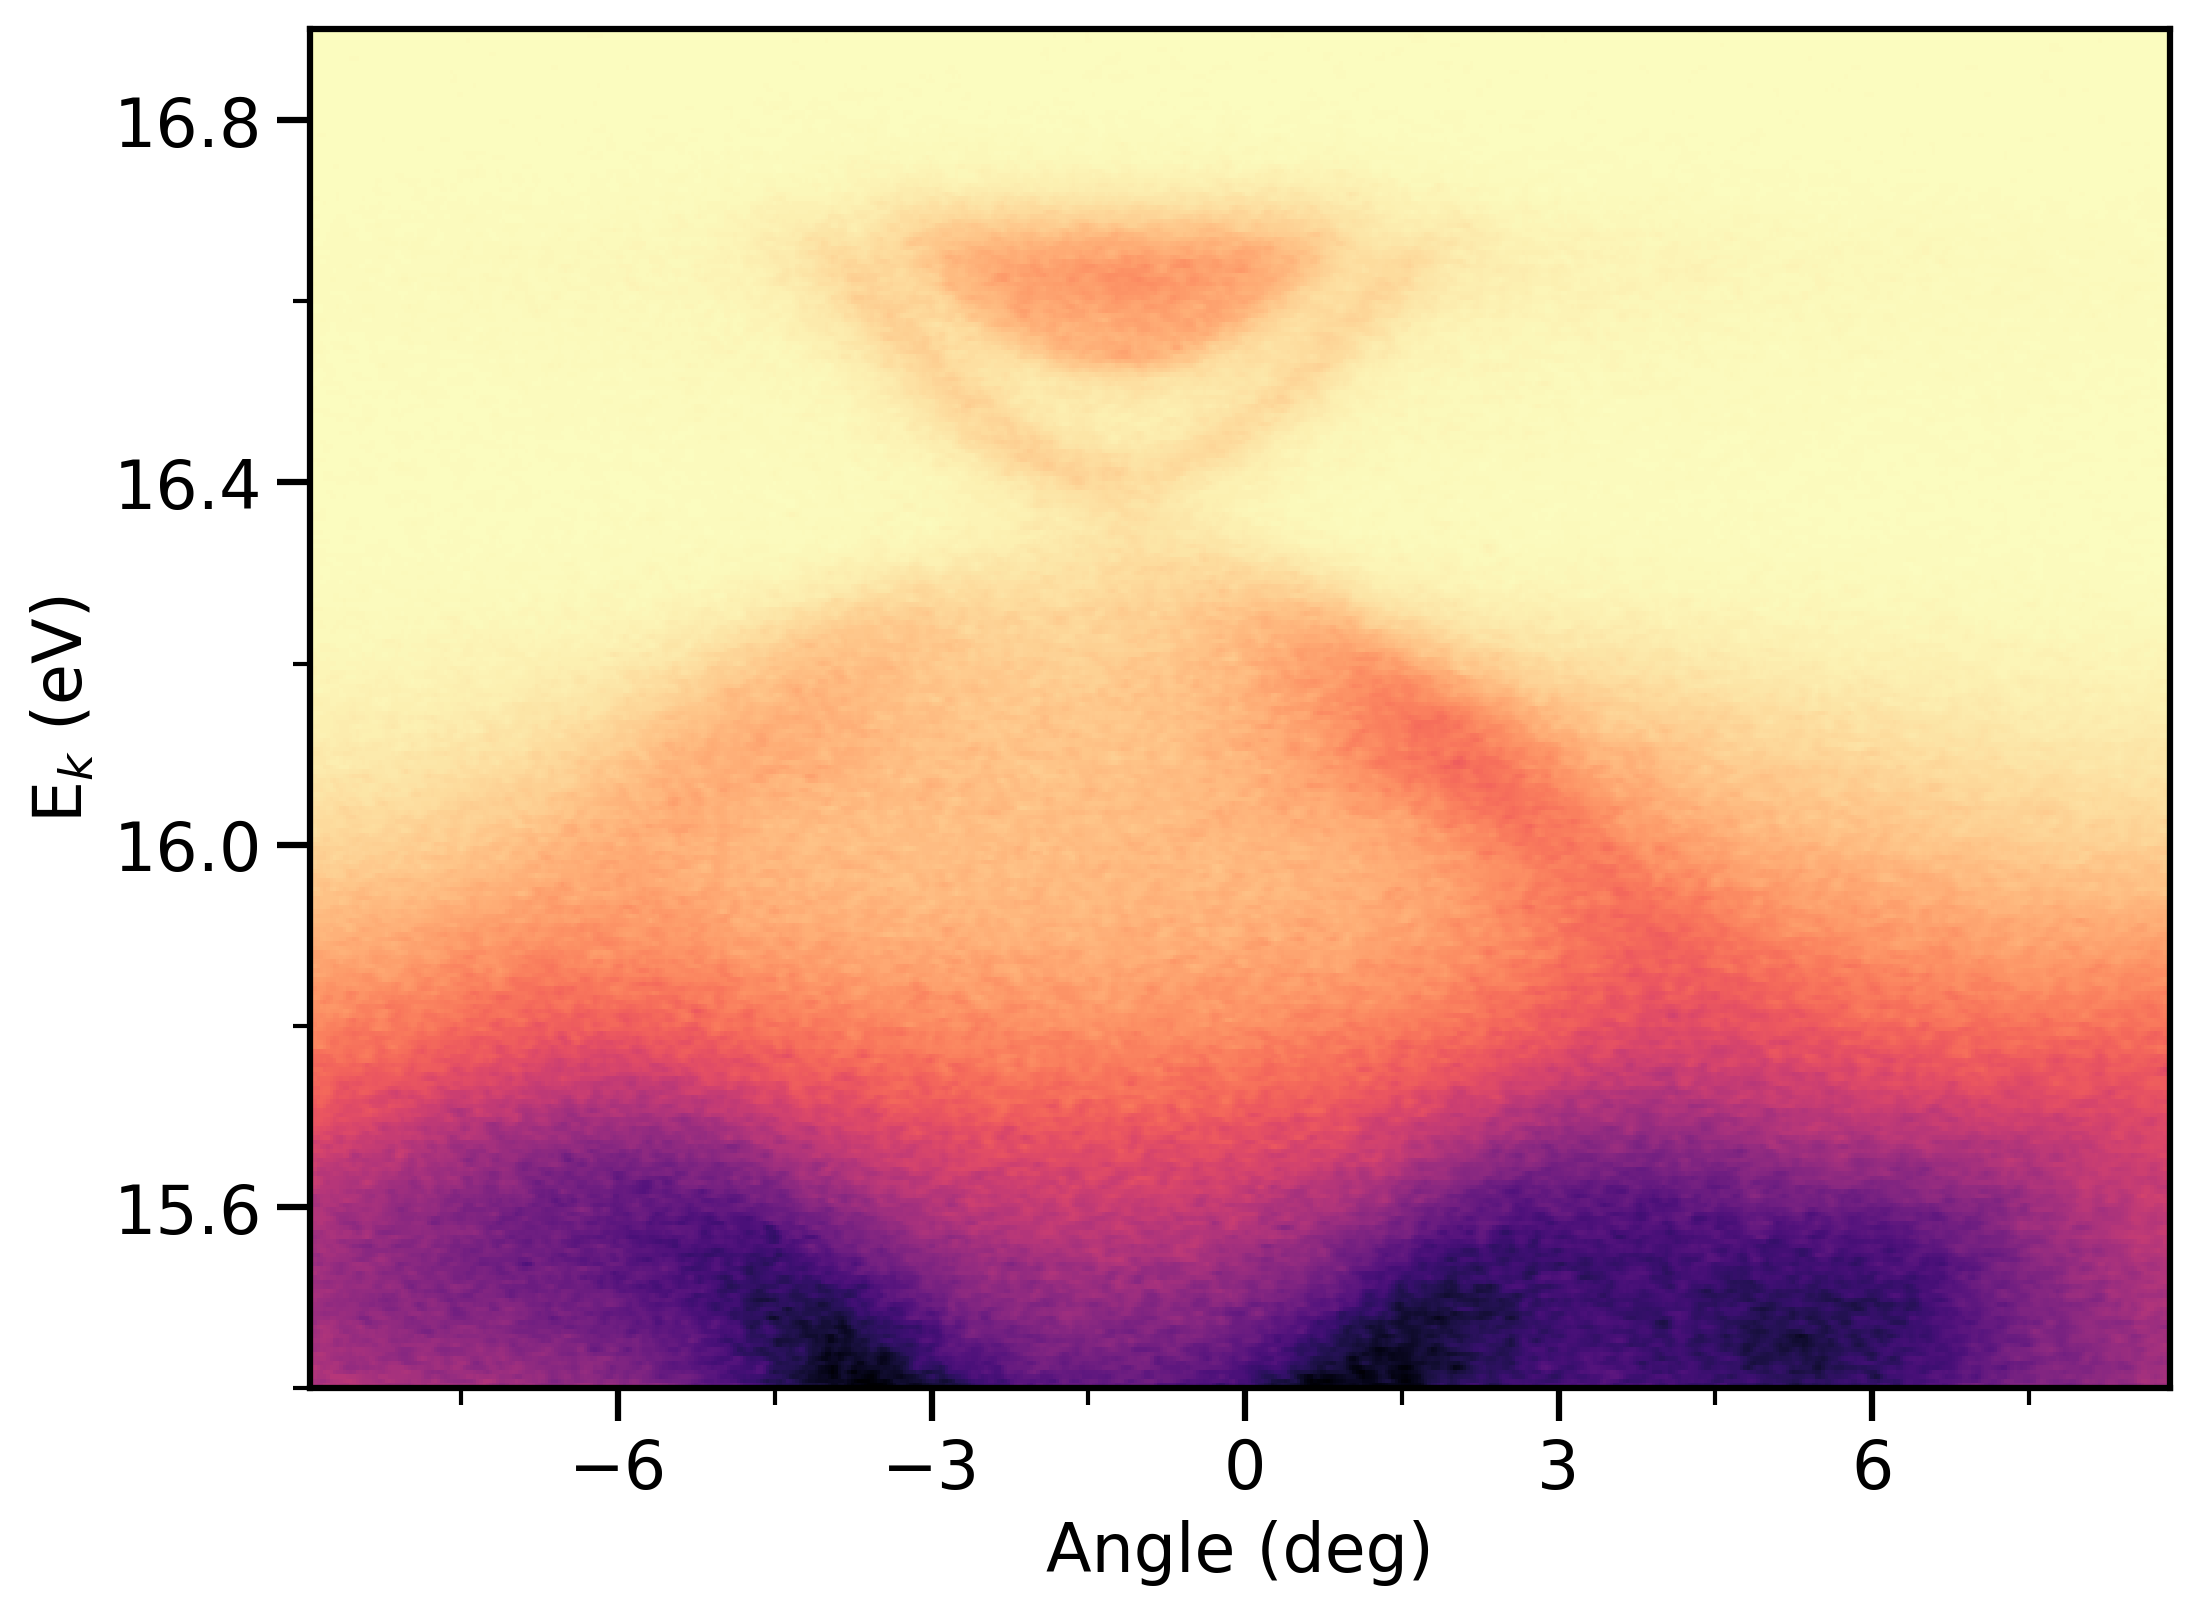

In [5]:
%matplotlib inline
my_image_plot(intensity, angle, energy)